In [1]:
import sklearn
from sklearn.cross_validation import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.grid_search import GridSearchCV
from sklearn.metrics import roc_auc_score
from sklearn.linear_model import LogisticRegressionCV, LogisticRegression
from sklearn.preprocessing import StandardScaler

import numpy as np
from joblib import Parallel, delayed
from collections import defaultdict, Counter
import itertools
import xgboost as xgb

from utils import parallel_groupby_and_apply, parallel_apply_to_rows, \
    save_pickle, read_pickle

import pandas as pd
pd.set_option('display.max_rows', 500)

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
%config IPCompleter.greedy = True
%config InlineBackend.figure_formats=['retina']
plt.rcParams['figure.figsize'] = 18, 9
plt.style.use('ggplot')
from IPython.display import Image, display

# Read Data

In [2]:
users_14 = pd.read_csv("ecml_pkkd_2016_dataset/users_2014.csv", na_values="-")
users_14.head(1)

,USER_ID,AGE_CAT,LOC_CAT,INC_CAT,GEN,LOC_GEO_X,LOC_GEO_Y,TARGET_TASK_2,C201401,C201402,...,W201403,W201404,W201405,W201406,W201407,W201408,W201409,W201410,W201411,W201412
0,30277,a,c,b,0,857400,334900,2014.04.30,0,0,...,0,0,0,0,0,0,0,0,0,0


In [3]:
train_14 = pd.read_csv("ecml_pkkd_2016_dataset/train_2014.csv", na_values="-")
train_14.head(1)

,USER_ID,POI_ID,CHANNEL,DATE,TIME_CAT,LOC_CAT,MC_CAT,CARD_CAT,AMT_CAT,GEO_X,GEO_Y
0,91498,28052,p,2014-01-01,a,b,b,d,b,605119.0,58997.8


In [4]:
poi = pd.read_csv("ecml_pkkd_2016_dataset/bank_info.csv")
poi.head(1)

,POI_ID,GEO_X,GEO_Y
0,17305.0,650283.0,239145.0


In [5]:
users_15 = pd.read_csv("ecml_pkkd_2016_dataset/users_2015.csv", na_values="-")
train_15 = pd.read_csv("ecml_pkkd_2016_dataset/train_2015.csv", na_values="-")
print Counter(users_15["AGE_CAT"])
users_15.loc[~users_15["AGE_CAT"].isin(["a", "b", "c"]), "AGE_CAT"] = "b"
print Counter(users_15["AGE_CAT"])

Counter({'b': 104832, 'a': 58834, 'c': 26933, nan: 638})
Counter({'b': 105470, 'a': 58834, 'c': 26933})


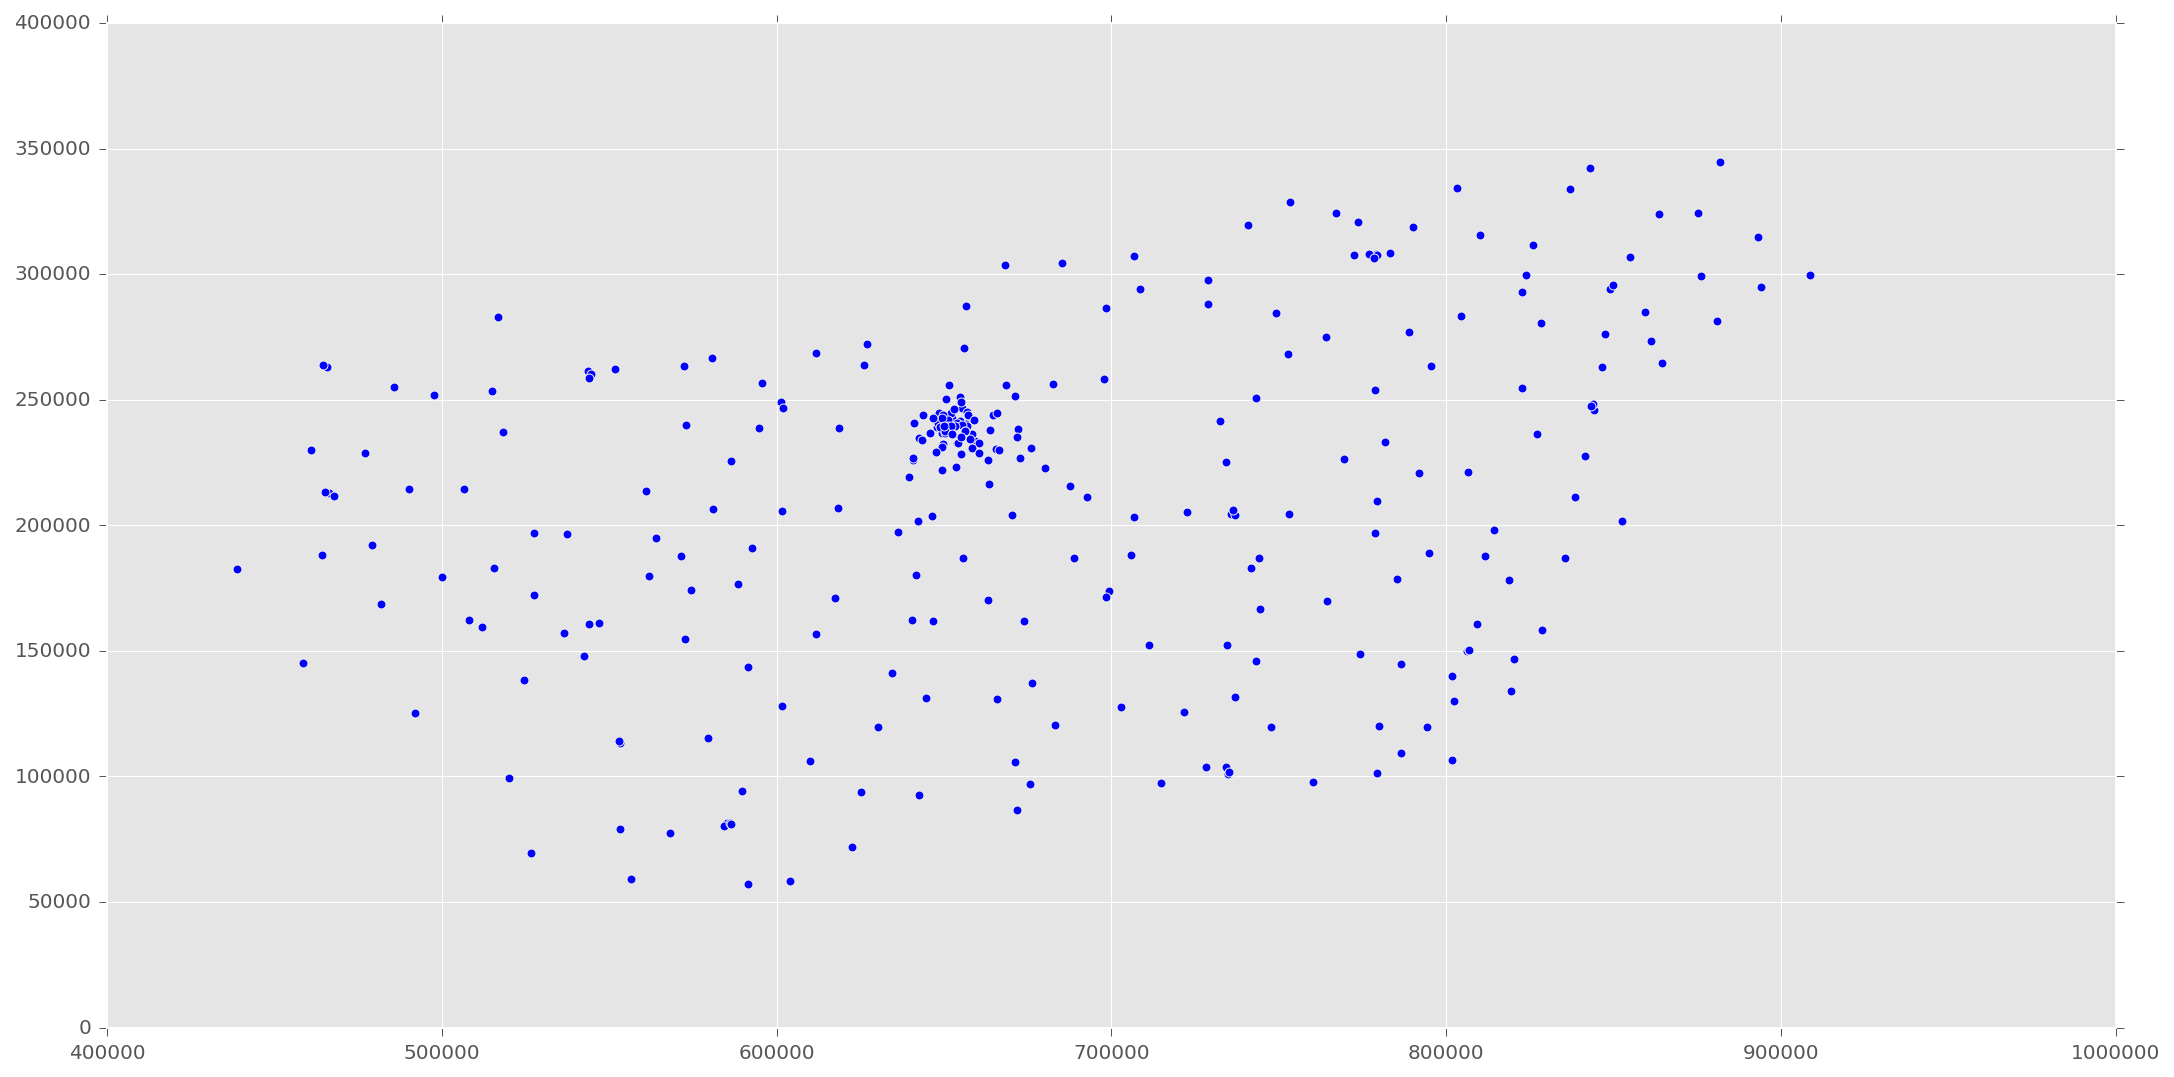

In [6]:
plt.scatter(poi["GEO_X"], poi["GEO_Y"])

In [7]:
# capital GEO
print np.mean(users_14[users_14["LOC_CAT"] == "a"]["LOC_GEO_X"])
print np.mean(users_14[users_14["LOC_CAT"] == "a"]["LOC_GEO_Y"])

653741.288883
239086.097913


# Train model

In [8]:
train_14.head()

,USER_ID,POI_ID,CHANNEL,DATE,TIME_CAT,LOC_CAT,MC_CAT,CARD_CAT,AMT_CAT,GEO_X,GEO_Y
0,91498,28052,p,2014-01-01,a,b,b,d,b,605119.0,58997.8
1,266177,1759,n,2014-01-01,a,NaN,j,d,b,NaN,NaN
2,202438,897,p,2014-01-01,a,b,b,d,c,698820.0,174757.0
3,109668,19939,p,2014-01-01,a,b,b,d,b,716050.0,271521.0
4,218581,13992,p,2014-01-01,a,a,j,d,c,653242.0,239511.0


In [9]:
users_14.head()

,USER_ID,AGE_CAT,LOC_CAT,INC_CAT,GEN,LOC_GEO_X,LOC_GEO_Y,TARGET_TASK_2,C201401,C201402,...,W201403,W201404,W201405,W201406,W201407,W201408,W201409,W201410,W201411,W201412
0,30277,a,c,b,0,857400,334900,2014.04.30,0,0,...,0,0,0,0,0,0,0,0,0,0
1,99045,b,b,b,0,699400,173300,NaN,0,0,...,0,0,0,0,0,0,0,0,0,0
2,19239,a,b,d,0,695900,170700,NaN,0,0,...,0,0,0,0,0,0,0,0,0,0
3,24396,a,b,a,0,585900,78300,NaN,0,0,...,0,0,0,0,0,0,0,0,0,0
4,111628,b,b,a,0,586000,78200,2015.06.30,1,1,...,0,0,0,0,0,0,0,0,0,0


In [10]:
users_with_target_mask = ~pd.isnull(users_14["TARGET_TASK_2"])
users_with_target = users_14[users_with_target_mask].sort_values("USER_ID")
users_wo_target = users_14[~users_with_target_mask]
print len(users_with_target), len(users_wo_target), len(users_14)

9135 182103 191238


In [11]:
def get_popular_pois(channel, min_in_target, limit):
    tmp = train_14[train_14["CHANNEL"] == channel][["USER_ID", "POI_ID"]].drop_duplicates()
    tmp = tmp.merge(users_with_target[["USER_ID"]], on="USER_ID")
    tmp2 = tmp.groupby("POI_ID", as_index=False).count()
    tmp2 = np.array(tmp2[tmp2["USER_ID"] > min_in_target]["POI_ID"])
    print len(tmp2)
    res = {}
    for poi_idx in tmp2:
        visited_poi = train_14[train_14["POI_ID"] == poi_idx]["USER_ID"].drop_duplicates()
        visited_good = np.sum(visited_poi.isin(users_with_target["USER_ID"]))
        visited_bad = np.sum(~visited_poi.isin(users_with_target["USER_ID"]))
        res[poi_idx] = (visited_good, visited_bad, visited_good / float(visited_good + visited_bad))
    for k, v in sorted(res.iteritems(), key=lambda x: -x[1][-1]):
        print k, v
    return sorted(map(lambda x: x[0], sorted(res.iteritems(), key=lambda x: -x[1][-1])[:limit]))
        
p_pois = get_popular_pois("p", 50, 200)
n_pois = get_popular_pois("n", 10, 40)

tmp = map(lambda x: (x, "n"), n_pois) + map(lambda x: (x, "p"), p_pois)
pop_poi_to_idx = {v: k for k, v in enumerate(tmp)}
print len(pop_poi_to_idx)

396
19470 (69, 412, 0.14345114345114346)
15551 (58, 379, 0.13272311212814644)
4614 (66, 432, 0.13253012048192772)
13298 (54, 373, 0.12646370023419204)
19823 (57, 394, 0.12638580931263857)
27109 (73, 509, 0.12542955326460481)
21111 (62, 433, 0.12525252525252525)
18205 (64, 460, 0.12213740458015267)
13848 (51, 384, 0.11724137931034483)
18210 (75, 568, 0.1166407465007776)
25693 (60, 456, 0.11627906976744186)
23720 (61, 464, 0.11619047619047619)
24251 (62, 478, 0.11481481481481481)
16992 (54, 417, 0.11464968152866242)
13404 (56, 434, 0.11428571428571428)
13137 (57, 446, 0.11332007952286283)
22793 (58, 456, 0.11284046692607004)
17335 (75, 595, 0.11194029850746269)
17879 (60, 476, 0.11194029850746269)
1848 (93, 742, 0.11137724550898204)
27600 (61, 487, 0.11131386861313869)
27403 (96, 769, 0.11098265895953757)
12911 (62, 497, 0.11091234347048301)
26787 (62, 498, 0.11071428571428571)
742 (54, 438, 0.10975609756097561)
3659 (56, 455, 0.1095890410958904)
12502 (96, 781, 0.10946408209806158)
1236

In [12]:
def user_row_to_feat(row):
    f = {}
    for k, v in dict(row).iteritems():
        if k in ["AGE_CAT", "LOC_CAT", "INC_CAT", "GEN", "LOC_GEO_X", "LOC_GEO_Y"]:
            f[k] = v
        if k[:3] in ("C20", "W20"):
            f[k[0] + k[-2:]] = v
    # make user features
    user_res = []
    user_res.extend([f["LOC_GEO_X"], f["LOC_GEO_Y"], 
                     np.sqrt(((f["LOC_GEO_X"] - 653741) ** 2 + (f["LOC_GEO_Y"] - 239086) ** 2))])
    
    # take C** and W** for months from utm
    tmpC = [0] * 6
    tmpW = [0] * 6
    for idx, m in enumerate(row["utm"][::-1]):
        m = m.split(".")[1]
        tmpC[-(idx + 1)] = f["C" + m]
        tmpW[-(idx + 1)] = f["W" + m]
    user_res.extend(tmpC + tmpW)
    user_res.append(f["GEN"])
    user_res.extend(list((np.array(["a", "b", "c"]) == f["AGE_CAT"]).astype(int)))
    user_res.extend(list((np.array(["a", "b", "c", "d"]) == f["INC_CAT"]).astype(int)))
    user_res.extend(list((np.array(["a", "b", "c"]) == f["LOC_CAT"]).astype(int)))
    return np.array([row["USER_ID"]] + user_res)
    
def users_to_features(users):
    res = parallel_apply_to_rows(
        users,
        user_row_to_feat,
        n_jobs=32
    )
    
    return {row[0]: row[1:] for row in res}

def list_to_dict(lst):
    return {k: v for v, k in enumerate(lst)}

fields_to_vals = {
    "TIME_CAT": ["a", "b", "c", ""],
    "LOC_CAT": ["a", "b", "c", ""],
    "MC_CAT": ["a", "b", "c", "d", "e", "f", "g", "h", "i", "j", ""],
    "CARD_CAT": ["c", "d", ""],
    "AMT_CAT": ["a", "b", "c", ""],
}
combs = [
    ["TIME_CAT", "LOC_CAT", "MC_CAT", "CARD_CAT", "AMT_CAT"],
]
combs_values_to_idx = []
for comb in combs:
    combs_values_to_idx.append(list_to_dict(list(itertools.product(
                    *[fields_to_vals[feat] for feat in comb]))))

def user_trans_to_features(user_trans):
    res = []
    for comb, comb_vals in zip(combs, combs_values_to_idx):
        data = np.zeros((len(comb_vals),))
        for (_, row) in user_trans.iterrows():
            data[comb_vals[tuple("" if pd.isnull(row[f]) else row[f] for f in comb)]] = 1
        res.append([np.sum(data)])
        if np.sum(data) > 0:
            data = data / float(np.sum(data))
        res.append(data)
        
    # counters for popular places (n and p)
    data = np.zeros((len(pop_poi_to_idx),))
    for (_, row) in user_trans.iterrows():
        if (row["POI_ID"], row["CHANNEL"]) in pop_poi_to_idx:
            data[pop_poi_to_idx[(row["POI_ID"], row["CHANNEL"])]] += 1
    res.append([np.sum(data)])
    if np.sum(data) > 0:
        data = data / float(np.sum(data))
    res.append(data)
    
    cnt_p = 0
    cnt_n = 0
    for (_, row) in user_trans.iterrows():
        if row["CHANNEL"] == "n":
            cnt_n += 1
        else:
            cnt_p += 1
    
    res.append([cnt_n, cnt_p])
    
    return np.hstack(res)

def trans_to_users_features(transactions):
    return dict(
        parallel_groupby_and_apply(
            transactions[transactions["CHANNEL"].isin(["p", "n"])],
            "USER_ID",
            user_trans_to_features,
            n_jobs=32
        )
    )

def make_features(users, transactions, utm, target=None):
    # only for users in utm for respective months
    dates_df = []
    for uid, ms in utm.iteritems():
        start_y, start_m = ms[0].split(".")
        stop_y, stop_m = ms[-1].split(".")
        dates_df.append([uid, "{0}-{1}-01".format(start_y, start_m),"{0}-{1}-31".format(stop_y, stop_m)])
    dates_df = pd.DataFrame(dates_df, columns=["USER_ID", "start_date", "end_date"])
    transactions = transactions.merge(dates_df)
    transactions = transactions[(transactions["DATE"] >= transactions["start_date"]) &
                                (transactions["DATE"] <= transactions["end_date"])]

    utm_df = pd.DataFrame(list(utm.iteritems()), columns=["USER_ID", "utm"])
    users = users.merge(utm_df)
    
    users_f = users_to_features(users)
    trans_f = trans_to_users_features(transactions)
    
    X = []
    Y = []
    if target is not None:
        for uid in sorted(target.iterkeys()):
            X.append(np.hstack((
                        users_f[uid],
                        trans_f.get(uid, [0] * len(trans_f.itervalues().next())))
            ))
            Y.append(target[uid])
    else:
        for uid in sorted(users["USER_ID"]):
            X.append(np.hstack((
                        users_f[uid],
                        trans_f.get(uid, [0] * len(trans_f.itervalues().next())))
            ))
    
    X = np.array(X)
    Y = pd.DataFrame(Y).fillna(0).as_matrix()
    
    return X, Y

In [13]:
%%time
utm = {}
target = {}
for uid in users_with_target[users_with_target["TARGET_TASK_2"] > '2014.06.30']["USER_ID"]:
    utm[uid] = ["2014.01", "2014.02", "2014.03", "2014.04", "2014.05", "2014.06"]
    target[uid] = 1
for uid in users_wo_target["USER_ID"]:
    utm[uid] = ["2014.01", "2014.02", "2014.03", "2014.04", "2014.05", "2014.06"]
    target[uid] = 0
    
XX, YY = make_features(users_14, train_14, utm, target)

# test, LB
# 0.6680, 0.6902
# 0.7010, 0.7079
# 0.7035, 0.7101
# 0.7043, 0.7110
# 0.7094, 0.7134

CPU times: user 48 s, sys: 11.3 s, total: 59.3 s
Wall time: 2min 40s


In [16]:
XX_1, XX_2, YY_1, YY_2 = train_test_split(XX, YY, test_size=0.25, random_state=42, stratify=YY)

In [17]:
print XX_1.shape, YY_1.shape, np.sum(YY_1)
print XX_2.shape, YY_2.shape, np.sum(YY_2)

(141031, 2382) (141031, 1) 4454
(47011, 2382) (47011, 1) 1485


In [18]:
%%time
XX_nn = XX.copy()
s = StandardScaler()
XX_nn[:, np.max(XX_nn, axis=0) > 1] = s.fit_transform(XX_nn[:, np.max(XX_nn, axis=0) > 1])
XX_1_nn, XX_2_nn = train_test_split(XX_nn, test_size=0.25, random_state=42, stratify=YY)

CPU times: user 3.78 s, sys: 2.14 s, total: 5.92 s
Wall time: 5.92 s


In [19]:
%%time
clf = LogisticRegression(penalty='l1', C=1)
clf.fit(XX_1_nn, YY_1.ravel())
print "train", roc_auc_score(YY_1.ravel(), clf.predict_proba(XX_1_nn)[:, 1])
print "test", roc_auc_score(YY_2.ravel(), clf.predict_proba(XX_2_nn)[:, 1])

train 0.718198655899
test 0.69846837808
CPU times: user 1min 34s, sys: 2.58 s, total: 1min 37s
Wall time: 1min 33s


In [20]:
selected_features = (clf.coef_[0] != 0)
print sum(selected_features)

265


In [24]:
%%time
clf = MatrixNet(trees=1000, depth=6)  # proprietary in-house GBT
clf.fit(XX_1_nn[:, selected_features], YY_1.ravel())
print "train", roc_auc_score(YY_1.ravel(), clf.predict_proba(XX_1_nn[:, selected_features])[:, 1])
print "test", roc_auc_score(YY_2.ravel(), clf.predict_proba(XX_2_nn[:, selected_features])[:, 1])

train 0.771844951649
test 0.711476995201
CPU times: user 9.6 s, sys: 46.6 s, total: 56.2 s
Wall time: 3min 37s


In [28]:
save_pickle(clf, "model.pickle")
clf = read_pickle("model.pickle")

In [48]:
# best found xgboost parameters
clf = xgb.XGBClassifier(n_estimators=500, max_depth=4, min_child_weight=20, learning_rate=0.03)
clf.fit(XX_1_nn[:, selected_features], YY_1.ravel())
print "train", roc_auc_score(YY_1.ravel(), clf.predict_proba(XX_1_nn[:, selected_features])[:, 1])
print "test", roc_auc_score(YY_2.ravel(), clf.predict_proba(XX_2_nn[:, selected_features])[:, 1])

train 0.746861699498
test 0.709048501681


# Submission

In [49]:
%%time
utm = {}
for uid in users_15["USER_ID"]:
    utm[uid] = ["2015.01", "2015.02", "2015.03", "2015.04", "2015.05", "2015.06"]

XXX, _ = make_features(users_15, train_15, utm)

CPU times: user 48 s, sys: 32.7 s, total: 1min 20s
Wall time: 3min 23s


In [50]:
XXX.shape

(191237, 2382)

In [51]:
XXX_nn = XXX.copy()
XXX_nn[:, np.max(XX_nn, axis=0) > 1] = s.fit_transform(XXX_nn[:, np.max(XX_nn, axis=0) > 1])

In [56]:
c = clf.predict_proba(XXX_nn[:, selected_features])[:, 1]

In [57]:
with open("submission2.csv", "w") as f:
    f.write("#USER_ID,SCORE\n")
    for uid, proba in zip(sorted(users_15["USER_ID"]), c):
        f.write("{0},{1}\n".format(uid, proba))

In [59]:
! head submission2.csv

#USER_ID,SCORE
1,0.0170267735888
2,0.0177719576088
4,0.0441158731675
5,0.0193728089392
6,0.0261968326774
9,0.0238231232508
12,0.00840575644266
13,0.0143631785201
14,0.0196082923624
